In [7]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [8]:
!ls
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

fashion-product-images-small.zip  kaggle.json	 sample_data
images				  myntradataset  styles.csv
fashion-product-images-small.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
uploaded = files.upload()

In [10]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Dec 16 02:33 kaggle.json


In [11]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

fashion-product-images-small.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!unzip \*.zip

Archive:  fashion-product-images-small.zip
replace images/10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images/10001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as tfk
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [15]:
import pandas as pd
import numpy as np
df = pd.read_csv('styles.csv', error_bad_lines=False)
df=df.dropna()
df.head(2)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans


In [16]:
targets = [ "Shirts", "Watches", "Sports Shoes", "Tops", "Handbags", "Heels", "Sunglasses", "Backpacks", "Jeans", "Shorts"]
df = df[df['articleType'].isin(targets)]

seed=111
np.random.seed(seed) 
large = ["Shirts", "Watches", "Sports Shoes", "Tops", "Handbags", "Heels", "Sunglasses"]
small = ["Backpacks", "Jeans", "Shorts"]
lst = []
for t in targets:
    temp = df[df['articleType'] == t]
    if t in small:
        lst.append(temp)
    else:
        lst.append(temp.sample(n = 1000, random_state = seed))
df = pd.concat(lst)
df.shape

(8874, 10)

In [202]:
#df.articleType.unique()
df['subCategory'].value_counts()

Shoes                       2000
Topwear                     2000
Bags                        1722
Bottomwear                  1148
Eyewear                     1000
Watches                     1000
Free Gifts                     2
Loungewear and Nightwear       2
Name: subCategory, dtype: int64

#temp

In [225]:
df['usage'].value_counts()

Casual          7204
Sports          1299
Formal           298
Ethnic            41
Travel            14
Smart Casual      13
Party              5
Name: usage, dtype: int64

In [203]:
df.iloc[:,[0,1,2,3,6,8]].head(2)

,id,gender,masterCategory,subCategory,season,usage
15691,33547,Men,Apparel,Topwear,Summer,Casual
18162,33492,Men,Apparel,Topwear,Summer,Casual


In [231]:
df_onehot = pd.get_dummies(df.iloc[:,[0,1,2,3,6,8]], columns=['gender', 'masterCategory','subCategory',"season","usage"], drop_first=True)
#df_onehot = pd.get_dummies(df.iloc[:,[0,1,2,3,4,6,8]], columns=['gender', 'articleType',"season","usage"], drop_first=True)

df_onehot=df_onehot.reset_index(drop=True)
df_onehot = pd.merge(df.iloc[:,[0,1,2,3,6,8]],df_onehot,  how='inner', on='id')


In [228]:
df_onehot.columns
#df_onehot.shape

Index(['id', 'gender', 'masterCategory', 'season', 'usage', 'gender_Girls',
       'gender_Men', 'gender_Unisex', 'gender_Women', 'masterCategory_Apparel',
       'masterCategory_Footwear', 'masterCategory_Free Items',
       'subCategory_Bottomwear', 'subCategory_Eyewear',
       'subCategory_Free Gifts', 'subCategory_Loungewear and Nightwear',
       'subCategory_Shoes', 'subCategory_Topwear', 'subCategory_Watches',
       'season_Spring', 'season_Summer', 'season_Winter', 'usage_Ethnic',
       'usage_Formal', 'usage_Party', 'usage_Smart Casual', 'usage_Sports',
       'usage_Travel'],
      dtype='object')

In [53]:
from keras.preprocessing import image
from tqdm import tqdm
X=[]
Y_id=[]
train_image = []
for i in tqdm(range(df_onehot.shape[0])):
  try:
    path = "myntradataset/images/{}.jpg".format(df_onehot['id'][i])
    img = image.load_img(path,target_size=(80,60))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
    Y_id.append(df_onehot['id'][i])
  except:
    pass

X = np.array(train_image)


100%|██████████| 8872/8872 [00:04<00:00, 2113.21it/s]


(8870, 80, 60, 3)


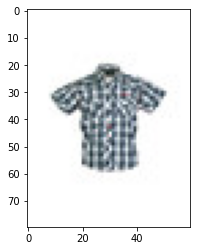

In [54]:
plt.imshow(X[1])
print(X.shape)

In [232]:
df_onehot = df_onehot.loc[~df_onehot.id.isin( list(set(df_onehot.id) - set(Y_id))),: ]
df_onehot # remove demaged images

,id,gender,masterCategory,subCategory,season,usage,gender_Girls,gender_Men,gender_Unisex,gender_Women,masterCategory_Apparel,masterCategory_Footwear,masterCategory_Free Items,subCategory_Bottomwear,subCategory_Eyewear,subCategory_Free Gifts,subCategory_Loungewear and Nightwear,subCategory_Shoes,subCategory_Topwear,subCategory_Watches,season_Spring,season_Summer,season_Winter,usage_Ethnic,usage_Formal,usage_Party,usage_Smart Casual,usage_Sports,usage_Travel
0,33547,Men,Apparel,Topwear,Summer,Casual,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,33492,Men,Apparel,Topwear,Summer,Casual,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,8829,Men,Apparel,Topwear,Fall,Casual,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,19198,Men,Apparel,Topwear,Fall,Casual,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,15981,Men,Apparel,Topwear,Fall,Casual,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8867,4797,Men,Apparel,Bottomwear,Summer,Sports,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8868,9075,Men,Apparel,Bottomwear,Fall,Sports,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8869,28627,Men,Apparel,Bottomwear,Summer,Sports,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8870,9081,Men,Apparel,Bottomwear,Fall,Sports,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [233]:
df_onehot.gender = pd.Categorical(df_onehot.gender)
df_onehot.usage = pd.Categorical(df_onehot.usage)
df_onehot.masterCategory = pd.Categorical(df_onehot.masterCategory)
df_onehot.season = pd.Categorical(df_onehot.season)
df_onehot.subCategory = pd.Categorical(df_onehot.subCategory)

In [212]:
df_onehot.columns

Index(['id', 'gender', 'masterCategory', 'season', 'usage', 'gender_Girls',
       'gender_Men', 'gender_Unisex', 'gender_Women', 'masterCategory_Apparel',
       'masterCategory_Footwear', 'masterCategory_Free Items',
       'subCategory_Bottomwear', 'subCategory_Eyewear',
       'subCategory_Free Gifts', 'subCategory_Loungewear and Nightwear',
       'subCategory_Shoes', 'subCategory_Topwear', 'subCategory_Watches',
       'season_Spring', 'season_Summer', 'season_Winter', 'usage_Ethnic',
       'usage_Formal', 'usage_Party', 'usage_Smart Casual', 'usage_Sports',
       'usage_Travel'],
      dtype='object')

In [215]:
# check order 
print(list(df_onehot.id) == Y_id)


# build y
Y = np.array(df_onehot.drop(['id', 'gender', 'masterCategory',
       'season', 'usage'],axis=1))
print('y shape:',Y.shape,'x shape:', X.shape)




True
y shape: (8870, 23) x shape: (8870, 80, 60, 3)


In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
print(f"train_X: {X_train.shape}, test_X = {X_test.shape}")

train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


# Multi class, multi labels

In [138]:
model1_1 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    #Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    #Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    #Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    #Dense(128, activation='relu'),
    #Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(16, activation='sigmoid')])

model1_1.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 76, 56, 32)        2432      
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 38, 28, 32)        0         
_________________________________________________________________
dropout_143 (Dropout)        (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 34, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 17, 12, 64)        0         
_________________________________________________________________
dropout_144 (Dropout)        (None, 17, 12, 64)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 13, 8, 128)      

In [139]:
#X_train, X_test, Y_train, Y_test
model1_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results1_1 = model1_1.fit(X_train, Y_train, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test, Y_test))


Epoch 1/10
111/111 [==============================] - 97s 872ms/step - loss: 0.3273 - accuracy: 0.2394 - val_loss: 0.2366 - val_accuracy: 0.2435
Epoch 2/10
111/111 [==============================] - 96s 867ms/step - loss: 0.2061 - accuracy: 0.2696 - val_loss: 0.1588 - val_accuracy: 0.2976
Epoch 3/10
111/111 [==============================] - 97s 873ms/step - loss: 0.1712 - accuracy: 0.2968 - val_loss: 0.1383 - val_accuracy: 0.2931
Epoch 4/10
111/111 [==============================] - 96s 867ms/step - loss: 0.1541 - accuracy: 0.2851 - val_loss: 0.1317 - val_accuracy: 0.2734
Epoch 5/10
111/111 [==============================] - 97s 871ms/step - loss: 0.1440 - accuracy: 0.2919 - val_loss: 0.1316 - val_accuracy: 0.2666
Epoch 6/10
111/111 [==============================] - 97s 877ms/step - loss: 0.1371 - accuracy: 0.3014 - val_loss: 0.1193 - val_accuracy: 0.3055
Epoch 7/10
111/111 [==============================] - 97s 871ms/step - loss: 0.1311 - accuracy: 0.3059 - val_loss: 0.1178 - val_ac

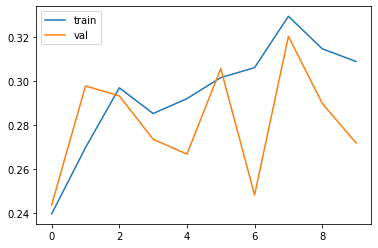

In [140]:
plt.plot(results1_1.history["accuracy"])
plt.plot(results1_1.history["val_accuracy"])
plt.legend(labels=["train", "val"])

In [120]:
df_onehot.columns


Index(['id', 'gender', 'masterCategory', 'season', 'usage', 'gender_Girls',
       'gender_Men', 'gender_Unisex', 'gender_Women', 'masterCategory_Apparel',
       'masterCategory_Footwear', 'masterCategory_Free Items', 'season_Spring',
       'season_Summer', 'season_Winter', 'usage_Ethnic', 'usage_Formal',
       'usage_Party', 'usage_Smart Casual', 'usage_Sports', 'usage_Travel'],
      dtype='object')

# multi class

In [142]:
df_onehot = df_onehot.assign(ColumnA = df_onehot.gender.astype(str) + ', ' + 
  df_onehot.masterCategory.astype(str) + ', ' + df_onehot.season.astype(str) + ', ' + df_onehot.usage.astype(str) )
df_onehot.ColumnA = pd.Categorical(df_onehot.ColumnA)
from keras.utils import  to_categorical
categ = 'ColumnA'
Y1_2 = np.array(df_onehot[categ].cat.codes)
Y1_2 = to_categorical(Y1_2)

print('y shape:',Y1_2.shape,'x shape:', X.shape)

X_train1_2, X_test1_2, Y_train1_2, Y_test1_2 = train_test_split(X, Y1_2, test_size=0.2)
print(f"train_X: {X_train1_2.shape}, test_X = {X_test1_2.shape}")

y shape: (8870, 99) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [ ]:
model1_2 = Sequential()

model1_2 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    #Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    #Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    #Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    #Dense(64, activation='relu'),
    #Dropout(0.25),
    #Dense(32, activation='relu'),
    Dense(99, activation='softmax')])

model1_2.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1_2.summary()


In [144]:
results1_2 = model1_2.fit(X_train1_2, Y_train1_2, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test1_2, Y_test1_2))

Epoch 1/10
111/111 [==============================] - 97s 874ms/step - loss: 3.0028 - accuracy: 0.2310 - val_loss: 2.1960 - val_accuracy: 0.4419
Epoch 2/10
111/111 [==============================] - 97s 877ms/step - loss: 1.9335 - accuracy: 0.4539 - val_loss: 1.8400 - val_accuracy: 0.4899
Epoch 3/10
111/111 [==============================] - 97s 878ms/step - loss: 1.6316 - accuracy: 0.5114 - val_loss: 1.5216 - val_accuracy: 0.5536
Epoch 4/10
111/111 [==============================] - 97s 876ms/step - loss: 1.4988 - accuracy: 0.5630 - val_loss: 1.4881 - val_accuracy: 0.5434
Epoch 5/10
111/111 [==============================] - 98s 879ms/step - loss: 1.3631 - accuracy: 0.5792 - val_loss: 1.4159 - val_accuracy: 0.5891
Epoch 6/10
111/111 [==============================] - 97s 878ms/step - loss: 1.2802 - accuracy: 0.5992 - val_loss: 1.3117 - val_accuracy: 0.6037
Epoch 7/10
111/111 [==============================] - 98s 884ms/step - loss: 1.2199 - accuracy: 0.6153 - val_loss: 1.3295 - val_ac

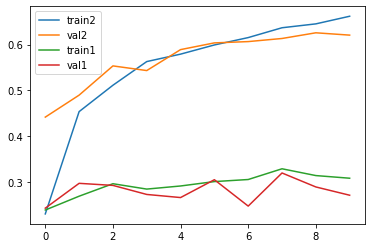

In [147]:
plt.plot(results1_2.history["accuracy"])
plt.plot(results1_2.history["val_accuracy"])
plt.plot(results1_1.history["accuracy"])
plt.plot(results1_1.history["val_accuracy"])
plt.legend(labels=["train2", "val2","train1", "val1"])

# MasterCategory


In [155]:
df_onehot.columns

Index(['id', 'gender', 'masterCategory', 'season', 'usage', 'gender_Girls',
       'gender_Men', 'gender_Unisex', 'gender_Women', 'masterCategory_Apparel',
       'masterCategory_Footwear', 'masterCategory_Free Items', 'season_Spring',
       'season_Summer', 'season_Winter', 'usage_Ethnic', 'usage_Formal',
       'usage_Party', 'usage_Smart Casual', 'usage_Sports', 'usage_Travel',
       'ColumnA'],
      dtype='object')

### Single class - multiple labels

In [156]:
# build y
from keras.utils import normalize, to_categorical
categ = [ 'masterCategory_Apparel',
       'masterCategory_Footwear', 'masterCategory_Free Items']
Y2 = np.array(df_onehot[categ])
print('y shape:',Y3.shape,'x shape:', X.shape)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y2, test_size=0.2)
print(f"train_X: {X_train2.shape}, test_X = {X_test2.shape}")

y shape: (8870, 8) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [ ]:

model2 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='sigmoid')])
model2.summary()


In [158]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results2 = model2.fit(X_train2, Y_train2, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test2, Y_test2))

Epoch 1/10
111/111 [==============================] - 89s 801ms/step - loss: 0.5156 - accuracy: 0.7010 - val_loss: 0.3962 - val_accuracy: 0.7830
Epoch 2/10
111/111 [==============================] - 88s 795ms/step - loss: 0.2994 - accuracy: 0.7899 - val_loss: 0.1950 - val_accuracy: 0.8388
Epoch 3/10
111/111 [==============================] - 88s 792ms/step - loss: 0.1745 - accuracy: 0.8829 - val_loss: 0.0927 - val_accuracy: 0.9273
Epoch 4/10
111/111 [==============================] - 88s 792ms/step - loss: 0.1192 - accuracy: 0.9173 - val_loss: 0.0669 - val_accuracy: 0.9329
Epoch 5/10
111/111 [==============================] - 88s 790ms/step - loss: 0.0853 - accuracy: 0.9235 - val_loss: 0.0581 - val_accuracy: 0.9707
Epoch 6/10
111/111 [==============================] - 88s 789ms/step - loss: 0.0715 - accuracy: 0.9153 - val_loss: 0.0345 - val_accuracy: 0.9628
Epoch 7/10
111/111 [==============================] - 88s 788ms/step - loss: 0.0541 - accuracy: 0.9049 - val_loss: 0.0320 - val_ac

### multi class, single labels

In [159]:
####  multi label -softmax 
# build y
from keras.utils import  to_categorical
categ = 'masterCategory'
Y3 = np.array(df_onehot[categ].cat.codes)
Y3 = to_categorical(Y3)

print('y shape:',Y3.shape,'x shape:', X.shape)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y3, test_size=0.2)
print(f"train_X: {X_train3.shape}, test_X = {X_test3.shape}")

y shape: (8870, 4) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [ ]:
model3 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='softmax')])

model3.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])

model3.summary()

In [166]:
results3 = model3.fit(X_train3, Y_train3, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test3, Y_test3))

Epoch 1/10
111/111 [==============================] - 88s 794ms/step - loss: 1.2238 - accuracy: 0.3952 - val_loss: 1.0621 - val_accuracy: 0.4882
Epoch 2/10
111/111 [==============================] - 89s 800ms/step - loss: 0.8496 - accuracy: 0.5559 - val_loss: 0.5410 - val_accuracy: 0.7289
Epoch 3/10
111/111 [==============================] - 88s 795ms/step - loss: 0.5595 - accuracy: 0.7462 - val_loss: 0.3468 - val_accuracy: 0.8641
Epoch 4/10
111/111 [==============================] - 89s 798ms/step - loss: 0.3667 - accuracy: 0.8598 - val_loss: 0.1672 - val_accuracy: 0.9312
Epoch 5/10
111/111 [==============================] - 89s 799ms/step - loss: 0.2432 - accuracy: 0.9160 - val_loss: 0.1209 - val_accuracy: 0.9532
Epoch 6/10
111/111 [==============================] - 88s 796ms/step - loss: 0.1776 - accuracy: 0.9421 - val_loss: 0.0826 - val_accuracy: 0.9713
Epoch 7/10
111/111 [==============================] - 89s 803ms/step - loss: 0.1355 - accuracy: 0.9573 - val_loss: 0.0647 - val_ac

multi class test [0.4  0.56 0.75 0.86 0.92 0.94 0.96 0.97 0.97 0.98]
multi class val [0.49 0.73 0.86 0.93 0.95 0.97 0.98 0.98 0.98 0.99]
multi label test [0.7  0.79 0.88 0.92 0.92 0.92 0.9  0.9  0.91 0.89]
multi label val [0.78 0.84 0.93 0.93 0.97 0.96 0.97 0.95 0.99 0.89]


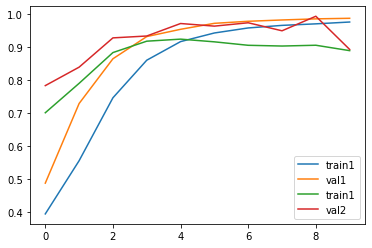

In [167]:
print("multi class test",np.around(np.array(results3.history["accuracy"]), 2))
print("multi class val",np.around(np.array(results3.history["val_accuracy"]), 2))
print("multi label test",np.around(np.array(results2.history["accuracy"]), 2))
print("multi label val",np.around(np.array(results2.history["val_accuracy"]), 2))

plt.plot(results3.history["accuracy"])
plt.plot(results3.history["val_accuracy"])
plt.plot(results2.history["accuracy"])
plt.plot(results2.history["val_accuracy"])
plt.legend(labels=["train1", "val1","train1", "val2"])


# season


In [148]:
df_onehot.columns

Index(['id', 'gender', 'masterCategory', 'season', 'usage', 'gender_Girls',
       'gender_Men', 'gender_Unisex', 'gender_Women', 'masterCategory_Apparel',
       'masterCategory_Footwear', 'masterCategory_Free Items', 'season_Spring',
       'season_Summer', 'season_Winter', 'usage_Ethnic', 'usage_Formal',
       'usage_Party', 'usage_Smart Casual', 'usage_Sports', 'usage_Travel',
       'ColumnA'],
      dtype='object')

In [190]:
# build y
from keras.utils import normalize, to_categorical
categ = ['season_Spring','season_Summer', 'season_Winter']
Y2 = np.array(df_onehot[categ])
print('y shape:',Y2.shape,'x shape:', X.shape)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y2, test_size=0.2)
print(f"train_X: {X_train2.shape}, test_X = {X_test2.shape}")


model2 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='sigmoid')])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

y shape: (8870, 3) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_230 (Conv2D)          (None, 76, 56, 32)        2432      
_________________________________________________________________
max_pooling2d_187 (MaxPoolin (None, 38, 28, 32)        0         
_________________________________________________________________
dropout_206 (Dropout)        (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 34, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_188 (MaxPoolin (None, 17, 12, 64)        0         
_________________________________________________________________
dropout_207 (Dropout)        (None, 17, 12, 64)        0         
__________________

In [191]:
results2 = model2.fit(X_train2, Y_train2, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test2, Y_test2))

Epoch 1/10
111/111 [==============================] - 89s 801ms/step - loss: 0.5274 - accuracy: 0.3967 - val_loss: 0.5105 - val_accuracy: 0.3980
Epoch 2/10
111/111 [==============================] - 88s 793ms/step - loss: 0.4814 - accuracy: 0.4302 - val_loss: 0.4632 - val_accuracy: 0.4797
Epoch 3/10
111/111 [==============================] - 88s 789ms/step - loss: 0.4482 - accuracy: 0.5154 - val_loss: 0.4340 - val_accuracy: 0.5372
Epoch 4/10
111/111 [==============================] - 88s 790ms/step - loss: 0.4192 - accuracy: 0.5637 - val_loss: 0.4042 - val_accuracy: 0.5761
Epoch 5/10
111/111 [==============================] - 88s 791ms/step - loss: 0.3901 - accuracy: 0.5998 - val_loss: 0.3788 - val_accuracy: 0.5868
Epoch 6/10
111/111 [==============================] - 88s 792ms/step - loss: 0.3722 - accuracy: 0.6143 - val_loss: 0.3654 - val_accuracy: 0.6172
Epoch 7/10
111/111 [==============================] - 88s 793ms/step - loss: 0.3590 - accuracy: 0.6301 - val_loss: 0.3544 - val_ac

In [192]:
####  multi label -softmax 
# build y
categ = 'season'
Y3 = np.array(df_onehot[categ].cat.codes)
Y3 = to_categorical(Y3)

print('y shape:',Y3.shape,'x shape:', X.shape)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y3, test_size=0.2)
print(f"train_X: {X_train3.shape}, test_X = {X_test3.shape}")

y shape: (8870, 4) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [195]:
model3 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')])

model3.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])

model3.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_238 (Conv2D)          (None, 76, 56, 32)        2432      
_________________________________________________________________
max_pooling2d_195 (MaxPoolin (None, 38, 28, 32)        0         
_________________________________________________________________
dropout_216 (Dropout)        (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 34, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_196 (MaxPoolin (None, 17, 12, 64)        0         
_________________________________________________________________
dropout_217 (Dropout)        (None, 17, 12, 64)        0         
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 13, 8, 64)       

In [196]:
results3 = model3.fit(X_train3, Y_train3, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test3, Y_test3))

Epoch 1/10
111/111 [==============================] - 88s 795ms/step - loss: 1.1754 - accuracy: 0.3973 - val_loss: 1.1000 - val_accuracy: 0.5158
Epoch 2/10
111/111 [==============================] - 89s 798ms/step - loss: 1.0318 - accuracy: 0.5307 - val_loss: 0.9227 - val_accuracy: 0.5868
Epoch 3/10
111/111 [==============================] - 88s 794ms/step - loss: 0.9372 - accuracy: 0.5909 - val_loss: 0.8496 - val_accuracy: 0.6342
Epoch 4/10
111/111 [==============================] - 88s 792ms/step - loss: 0.8742 - accuracy: 0.6237 - val_loss: 0.9978 - val_accuracy: 0.5327
Epoch 5/10
111/111 [==============================] - 88s 790ms/step - loss: 0.8333 - accuracy: 0.6313 - val_loss: 0.7871 - val_accuracy: 0.6742
Epoch 6/10
111/111 [==============================] - 88s 792ms/step - loss: 0.8044 - accuracy: 0.6497 - val_loss: 0.7561 - val_accuracy: 0.6855
Epoch 7/10
111/111 [==============================] - 88s 790ms/step - loss: 0.7913 - accuracy: 0.6609 - val_loss: 0.7406 - val_ac

multi class test [0.4  0.53 0.59 0.62 0.63 0.65 0.66 0.67 0.67 0.68]
multi class val [0.52 0.59 0.63 0.53 0.67 0.69 0.69 0.7  0.7  0.7 ]
multi label test [0.4  0.43 0.52 0.56 0.6  0.61 0.63 0.64 0.65 0.66]
multi label val [0.4  0.48 0.54 0.58 0.59 0.62 0.61 0.62 0.64 0.65]


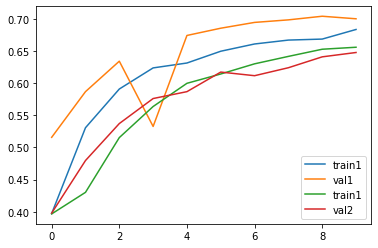

In [197]:
print("multi class test",np.around(np.array(results3.history["accuracy"]), 2))
print("multi class val",np.around(np.array(results3.history["val_accuracy"]), 2))
print("multi label test",np.around(np.array(results2.history["accuracy"]), 2))
print("multi label val",np.around(np.array(results2.history["val_accuracy"]), 2))
plt.plot(results3.history["accuracy"])
plt.plot(results3.history["val_accuracy"])
plt.plot(results2.history["accuracy"])
plt.plot(results2.history["val_accuracy"])
plt.legend(labels=["train1", "val1","train1", "val2"])

# gender

In [183]:
categ = ['gender_Girls',
       'gender_Men', 'gender_Unisex', 'gender_Women']


Y2 = df_onehot[categ]
Y2.loc[Y2.gender_Unisex==1,['gender_Men', 'gender_Women']] = 1
Y2 = np.array(Y2[ ['gender_Girls',
       'gender_Men', 'gender_Women']])

print('y shape:',Y2.shape,'x shape:', X.shape)

y shape: (8870, 3) x shape: (8870, 80, 60, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
categ = ['gender_Girls',
       'gender_Men', 'gender_Unisex', 'gender_Women']

Y2 = np.array(df_onehot[categ])

print('y shape:',Y2.shape,'x shape:', X.shape)

In [184]:
# build sigmiod


X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y2, test_size=0.2)
print(f"train_X: {X_train2.shape}, test_X = {X_test2.shape}")


model2 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='sigmoid')])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

results2 = model2.fit(X_train2, Y_train2, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test2, Y_test2))

train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_218 (Conv2D)          (None, 76, 56, 32)        2432      
_________________________________________________________________
max_pooling2d_175 (MaxPoolin (None, 38, 28, 32)        0         
_________________________________________________________________
dropout_191 (Dropout)        (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 34, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_176 (MaxPoolin (None, 17, 12, 64)        0         
_________________________________________________________________
dropout_192 (Dropout)        (None, 17, 12, 64)        0         
________________________________________________________________

In [188]:
####  multi label -softmax 
# build y
categ = 'gender'
Y3 = np.array(df_onehot[categ].cat.codes)
Y3 = to_categorical(Y3)

print('y shape:',Y3.shape,'x shape:', X.shape)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y3, test_size=0.2)
print(f"train_X: {X_train3.shape}, test_X = {X_test3.shape}")


model3 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(5, activation='softmax')])

model3.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model3.summary()
results3 = model3.fit(X_train3, Y_train3, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test3, Y_test3))


y shape: (8870, 5) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)
Epoch 1/10
111/111 [==============================] - 88s 793ms/step - loss: 1.2622 - accuracy: 0.4085 - val_loss: 1.1693 - val_accuracy: 0.4724
Epoch 2/10
111/111 [==============================] - 88s 790ms/step - loss: 1.0913 - accuracy: 0.4642 - val_loss: 1.0021 - val_accuracy: 0.4741
Epoch 3/10
111/111 [==============================] - 88s 792ms/step - loss: 0.9394 - accuracy: 0.5686 - val_loss: 0.8261 - val_accuracy: 0.6122
Epoch 4/10
111/111 [==============================] - 88s 796ms/step - loss: 0.8130 - accuracy: 0.6733 - val_loss: 0.7211 - val_accuracy: 0.7525
Epoch 5/10
111/111 [==============================] - 88s 792ms/step - loss: 0.7273 - accuracy: 0.7201 - val_loss: 0.7389 - val_accuracy: 0.7492
Epoch 6/10
111/111 [==============================] - 88s 789ms/step - loss: 0.6795 - accuracy: 0.7565 - val_loss: 0.6081 - val_accuracy: 0.7835
Epoch 7/10
111/111 [=========

multi class test [0.41 0.46 0.57 0.67 0.72 0.76 0.77 0.79 0.8  0.81]
multi class val [0.47 0.47 0.61 0.75 0.75 0.78 0.78 0.8  0.78 0.75]
multi label test [0.47 0.5  0.65 0.76 0.8  0.82 0.83 0.83 0.84 0.85]
multi label val [0.45 0.57 0.76 0.78 0.78 0.82 0.83 0.83 0.83 0.85]


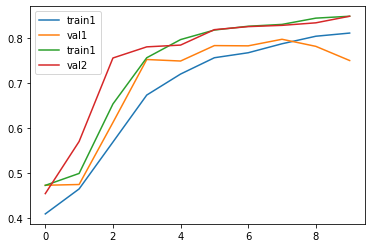

In [189]:
print("multi class test",np.around(np.array(results3.history["accuracy"]), 2))
print("multi class val",np.around(np.array(results3.history["val_accuracy"]), 2))
print("multi label test",np.around(np.array(results2.history["accuracy"]), 2))
print("multi label val",np.around(np.array(results2.history["val_accuracy"]), 2))
plt.plot(results3.history["accuracy"])
plt.plot(results3.history["val_accuracy"])
plt.plot(results2.history["accuracy"])
plt.plot(results2.history["val_accuracy"])
plt.legend(labels=["train1", "val1","train1", "val2"])

In [ ]:
a= '[0.41 0.46 0.57 0.67 0.72 0.76 0.77 0.79 0.8  0.81]'
b= '[0.47 0.47 0.61 0.75 0.75 0.78 0.78 0.8  0.78 0.75]'
c= '[0.47 0.5  0.65 0.76 0.8  0.82 0.83 0.83 0.84 0.85]'
d= '[0.45 0.57 0.76 0.78 0.78 0.82 0.83 0.83 0.83 0.85]'
print(a.replace(" ", ","))  
print(b.replace(" ", ","))  
print(c.replace(" ", ","))  
print(d.replace(" ", ","))  



In [ ]:
a=
b=
c=
d=
plt.plot(c)
plt.plot(d)
plt.plot(a)
plt.plot(b)
plt.legend(labels=["train1", "val1","train1", "val2"])

# usage

In [198]:
# build sigmiod
from keras.utils import normalize, to_categorical
categ = ['usage_Ethnic', 'usage_Formal',
       'usage_Party', 'usage_Smart Casual', 'usage_Sports', 'usage_Travel']
Y2 = np.array(df_onehot[categ])
print('y shape:',Y2.shape,'x shape:', X.shape)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y2, test_size=0.2)
print(f"train_X: {X_train2.shape}, test_X = {X_test2.shape}")


y shape: (8870, 6) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [199]:


model2 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(6, activation='sigmoid')])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()



Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_242 (Conv2D)          (None, 76, 56, 32)        2432      
_________________________________________________________________
max_pooling2d_199 (MaxPoolin (None, 38, 28, 32)        0         
_________________________________________________________________
dropout_221 (Dropout)        (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_243 (Conv2D)          (None, 34, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_200 (MaxPoolin (None, 17, 12, 64)        0         
_________________________________________________________________
dropout_222 (Dropout)        (None, 17, 12, 64)        0         
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 13, 8, 64)       

In [200]:
results2 = model2.fit(X_train2, Y_train2, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test2, Y_test2))

Epoch 1/10
111/111 [==============================] - 89s 799ms/step - loss: 0.6146 - accuracy: 0.1477 - val_loss: 0.5543 - val_accuracy: 0.1426
Epoch 2/10
111/111 [==============================] - 88s 792ms/step - loss: 0.4308 - accuracy: 0.1473 - val_loss: 0.3354 - val_accuracy: 0.1426
Epoch 3/10
111/111 [==============================] - 88s 795ms/step - loss: 0.2355 - accuracy: 0.1473 - val_loss: 0.1305 - val_accuracy: 0.1426
Epoch 4/10
111/111 [==============================] - 88s 793ms/step - loss: 0.1161 - accuracy: 0.1487 - val_loss: 0.0837 - val_accuracy: 0.1640
Epoch 5/10
111/111 [==============================] - 88s 794ms/step - loss: 0.0924 - accuracy: 0.1597 - val_loss: 0.0996 - val_accuracy: 0.1691
Epoch 6/10
111/111 [==============================] - 88s 795ms/step - loss: 0.0786 - accuracy: 0.1681 - val_loss: 0.0710 - val_accuracy: 0.1708
Epoch 7/10
111/111 [==============================] - 89s 802ms/step - loss: 0.0684 - accuracy: 0.1705 - val_loss: 0.0625 - val_ac

In [216]:
####  multi label -softmax 
# build y
from keras.utils import  to_categorical
categ = 'usage'
Y3 = np.array(df_onehot[categ].cat.codes)
Y3 = to_categorical(Y3)

print('y shape:',Y3.shape,'x shape:', X.shape)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y3, test_size=0.2)
print(f"train_X: {X_train3.shape}, test_X = {X_test3.shape}")


y shape: (8870, 7) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [ ]:


model3 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')])

model3.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])

model3.summary()



In [219]:
results3 = model3.fit(X_train3, Y_train3, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test3, Y_test3))

Epoch 1/10
111/111 [==============================] - 89s 803ms/step - loss: 0.7778 - accuracy: 0.7845 - val_loss: 0.6774 - val_accuracy: 0.8078
Epoch 2/10
111/111 [==============================] - 89s 803ms/step - loss: 0.6118 - accuracy: 0.8138 - val_loss: 0.6213 - val_accuracy: 0.8326
Epoch 3/10
111/111 [==============================] - 90s 807ms/step - loss: 0.5018 - accuracy: 0.8416 - val_loss: 0.4348 - val_accuracy: 0.8828
Epoch 4/10
111/111 [==============================] - 90s 806ms/step - loss: 0.4166 - accuracy: 0.8778 - val_loss: 0.3610 - val_accuracy: 0.9030
Epoch 5/10
111/111 [==============================] - 89s 803ms/step - loss: 0.3658 - accuracy: 0.9014 - val_loss: 0.2934 - val_accuracy: 0.9154
Epoch 6/10
111/111 [==============================] - 89s 804ms/step - loss: 0.3227 - accuracy: 0.9133 - val_loss: 0.3169 - val_accuracy: 0.9245
Epoch 7/10
111/111 [==============================] - 90s 808ms/step - loss: 0.3102 - accuracy: 0.9193 - val_loss: 0.2731 - val_ac

multi class test [0.78 0.81 0.84 0.88 0.9  0.91 0.92 0.92 0.92 0.93]
multi class val [0.81 0.83 0.88 0.9  0.92 0.92 0.92 0.93 0.92 0.93]
multi label test [0.15 0.15 0.15 0.15 0.16 0.17 0.17 0.17 0.17 0.17]
multi label val [0.14 0.14 0.14 0.16 0.17 0.17 0.17 0.18 0.17 0.18]


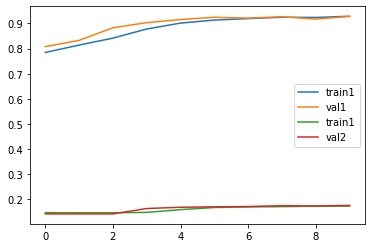

In [220]:
print("multi class test",np.around(np.array(results3.history["accuracy"]), 2))
print("multi class val",np.around(np.array(results3.history["val_accuracy"]), 2))
print("multi label test",np.around(np.array(results2.history["accuracy"]), 2))
print("multi label val",np.around(np.array(results2.history["val_accuracy"]), 2))
plt.plot(results3.history["accuracy"])
plt.plot(results3.history["val_accuracy"])
plt.plot(results2.history["accuracy"])
plt.plot(results2.history["val_accuracy"])
plt.legend(labels=["train1", "val1","train1", "val2"])

# subcategory

In [221]:
# build sigmiod
from keras.utils import normalize, to_categorical
categ = ['subCategory_Bottomwear', 'subCategory_Eyewear',
       'subCategory_Free Gifts', 'subCategory_Loungewear and Nightwear',
       'subCategory_Shoes', 'subCategory_Topwear', 'subCategory_Watches',]
Y2 = np.array(df_onehot[categ])
print('y shape:',Y2.shape,'x shape:', X.shape)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y2, test_size=0.2)
print(f"train_X: {X_train2.shape}, test_X = {X_test2.shape}")


y shape: (8870, 7) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [239]:
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(7, activation='sigmoid')])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_258 (Conv2D)          (None, 76, 56, 32)        2432      
_________________________________________________________________
max_pooling2d_215 (MaxPoolin (None, 38, 28, 32)        0         
_________________________________________________________________
dropout_241 (Dropout)        (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_259 (Conv2D)          (None, 34, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_216 (MaxPoolin (None, 17, 12, 64)        0         
_________________________________________________________________
dropout_242 (Dropout)        (None, 17, 12, 64)        0         
_________________________________________________________________
conv2d_260 (Conv2D)          (None, 13, 8, 64)       

In [240]:
results2 = model2.fit(X_train2, Y_train2, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test2, Y_test2))

Epoch 1/10
111/111 [==============================] - 88s 794ms/step - loss: 0.5326 - accuracy: 0.1053 - val_loss: 0.3777 - val_accuracy: 0.2249
Epoch 2/10
111/111 [==============================] - 88s 790ms/step - loss: 0.2848 - accuracy: 0.3994 - val_loss: 0.1688 - val_accuracy: 0.6003
Epoch 3/10
111/111 [==============================] - 91s 816ms/step - loss: 0.1637 - accuracy: 0.6277 - val_loss: 0.0927 - val_accuracy: 0.7221
Epoch 4/10
111/111 [==============================] - 88s 794ms/step - loss: 0.1108 - accuracy: 0.7120 - val_loss: 0.0560 - val_accuracy: 0.7700
Epoch 5/10
111/111 [==============================] - 88s 795ms/step - loss: 0.0852 - accuracy: 0.7332 - val_loss: 0.0468 - val_accuracy: 0.7790
Epoch 6/10
111/111 [==============================] - 88s 790ms/step - loss: 0.0671 - accuracy: 0.7558 - val_loss: 0.0351 - val_accuracy: 0.7909
Epoch 7/10
111/111 [==============================] - 88s 789ms/step - loss: 0.0572 - accuracy: 0.7679 - val_loss: 0.0291 - val_ac

In [235]:
####  multi label -softmax 
# build y
from keras.utils import  to_categorical
categ = 'subCategory'
Y3 = np.array(df_onehot[categ].cat.codes)
Y3 = to_categorical(Y3)

print('y shape:',Y3.shape,'x shape:', X.shape)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y3, test_size=0.2)
print(f"train_X: {X_train3.shape}, test_X = {X_test3.shape}")




y shape: (8870, 8) x shape: (8870, 80, 60, 3)
train_X: (7096, 80, 60, 3), test_X = (1774, 80, 60, 3)


In [ ]:
model3 = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(8, activation='softmax')])

model3.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])

model3.summary()


In [238]:
results3 = model3.fit(X_train3, Y_train3, 
          epochs=10, 
          batch_size = 64,
          validation_data=(X_test3, Y_test3))

Epoch 1/10
111/111 [==============================] - 89s 798ms/step - loss: 1.6351 - accuracy: 0.3492 - val_loss: 1.0339 - val_accuracy: 0.7063
Epoch 2/10
111/111 [==============================] - 89s 799ms/step - loss: 0.7998 - accuracy: 0.7118 - val_loss: 0.4226 - val_accuracy: 0.8529
Epoch 3/10
111/111 [==============================] - 90s 807ms/step - loss: 0.4818 - accuracy: 0.8341 - val_loss: 0.2739 - val_accuracy: 0.9098
Epoch 4/10
111/111 [==============================] - 89s 803ms/step - loss: 0.3646 - accuracy: 0.8805 - val_loss: 0.1992 - val_accuracy: 0.9397
Epoch 5/10
111/111 [==============================] - 89s 800ms/step - loss: 0.2927 - accuracy: 0.9068 - val_loss: 0.1335 - val_accuracy: 0.9605
Epoch 6/10
111/111 [==============================] - 89s 806ms/step - loss: 0.2477 - accuracy: 0.9290 - val_loss: 0.1452 - val_accuracy: 0.9526
Epoch 7/10
111/111 [==============================] - 89s 804ms/step - loss: 0.2038 - accuracy: 0.9379 - val_loss: 0.1161 - val_ac

multi class test [0.35 0.71 0.83 0.88 0.91 0.93 0.94 0.95 0.95 0.96]
multi class val [0.71 0.85 0.91 0.94 0.96 0.95 0.97 0.96 0.97 0.97]
multi label test [0.11 0.4  0.63 0.71 0.73 0.76 0.77 0.78 0.79 0.8 ]
multi label val [0.22 0.6  0.72 0.77 0.78 0.79 0.8  0.8  0.8  0.81]


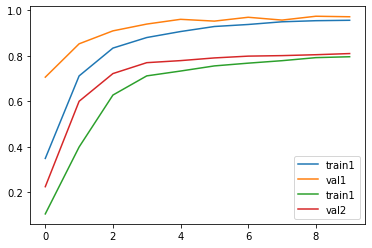

In [241]:
print("multi class test",np.around(np.array(results3.history["accuracy"]), 2))
print("multi class val",np.around(np.array(results3.history["val_accuracy"]), 2))
print("multi label test",np.around(np.array(results2.history["accuracy"]), 2))
print("multi label val",np.around(np.array(results2.history["val_accuracy"]), 2))
plt.plot(results3.history["accuracy"])
plt.plot(results3.history["val_accuracy"])
plt.plot(results2.history["accuracy"])
plt.plot(results2.history["val_accuracy"])
plt.legend(labels=["train1", "val1","train1", "val2"])

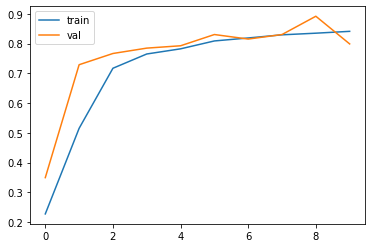

In [62]:
# subcate 
plt.plot(results2.history["accuracy"])
plt.plot(results2.history["val_accuracy"])
plt.legend(labels=["train", "val"])

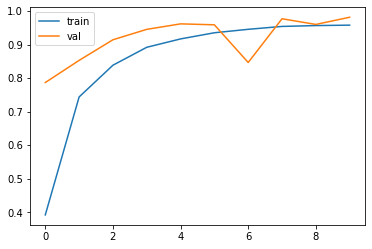

In [98]:
# subcategory
plt.plot(results3.history["accuracy"])
plt.plot(results3.history["val_accuracy"])
plt.legend(labels=["train", "val"])

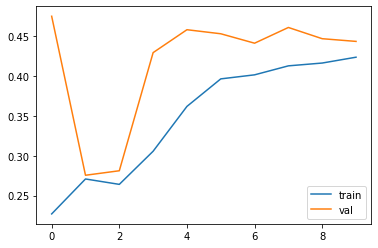

In [ ]:
# save the image!!! don't run this plot
plt.plot(results1.history["accuracy"])
plt.plot(results1.history["val_accuracy"])
plt.legend(labels=["train", "val"])


# end 


method 
2 classification
CNN model is a type of Neural Networks, which proved wildly effective, that mainly be used in image recognition and classification field. Our project applied 3 different classifiers based on CNN models: 
1. Multi-Class Single-Labels CNN. A classification task work with one column that includes more than 2 categorical variables. We selected ReLU as the activation function for Cov layers and Softmax as the last layer of the model. For example, in 'gender' column which containing:['Girls', 'Boys,' 'Men', 'Unisex', 'Women'], the unisex will be marked as [0,0,0,1,0]
2. Binary-Class Multi-Labels CNN. Also, a classification works with multiple binary columns. We set multiple Sigmoid activation functions on the last layer of the model. Mathematically, the output of each category is independent. In contrast, the outputs of a softmax are all interrelated. For example the 'unisex' will be marked as [0,0,1,1] (['Girls', 'Boys,' 'Men',  'Women'])
3. Multi-Class, Multi Labels CNN. This classification works with multiple columns that include multiple labels. We considered all the columns here. Thus we transformed our target value to the format of the previous two classify target. 1. One hot encoded all the categorical variables (in total 16 columns) 2. Combined all the columns, assigning to a new categorial column that has 99 different elements.  Then used Sigmoid and Softmax function in the last layer of CNN model respectively. 



result
The following figure shows the accuracy of our classifications by the various classifiers
总的来说，很明显

discussion:
对于分类，我们的目标是为了更精确的得到结果。然而我们的7种不同的分类，每一分类下面有多种不同的labels，换句话来说 就是multi-label and multi class classification。 那么我们面临最大的难题的就是如何处理这些


# 恩达


method
2 classification
CNN model is a type of Neural Networks, which proved wildly effective, that mainly be used in image recognition and classification field. Our project applied 2 different types of classifier and built several models based on CNN algorithm:
1. Multi-Class classifier. A classification works with one set of tags that includes more than 2 categorical variables, each image only be assigned one tag. We selected ReLU as the activation function for Cov layers and Softmax as the last layer of the model .
2. Multi-Labels classifier. A classification works with multiple sets of tags. An image can be assigned more than one tag. As the figure shows, an image can be marked as "Men" and "Women" at the same time to representing unisex. We set multiple Sigmoid activation functions on the last layer of the model. Mathematically, the output of each category is independent. In contrast, the outputs of a softmax are all interrelated.





result

The following figure shows the accuracy of our classifications by the various classifiers (blue and orange line represent the multi-class model; green and red lines represent the multi-label model)
In general, for the single category models, the accuracies of the two type classifiers are similar (except column usage), but when we faced the single model with multiple outputs, the Multi-Class classifier is much more accuracy.


discussion:
For classification, our goal is to more accurately mark each image with the prepared tag.
Our data contains too many categories, and each category includes multiple labels
 Then the biggest problem we face is how to deal with these handling these classes and labels. From the result table, we can know that if we build multiple cnn models to calculate the classification of each class, the final accuracy rate of all tags is * ****. The accuracy rate is higher than that of building a multi-output model.

In addition, Multi-Labels Classfier is extremely susceptible to imbalanced data. For example, the labels of the Usage column, of the 7 labels, three labels account for 98%, and the softmax activate function is very good 

In [ ]:
from skimage import io
img_id = 51623
path = "myntradataset/images/{}.jpg".format(img_id)
img1 = io.imread(path)
io.imshow(img1)